# Kaggle Titanic Machine Learning Challenge
Katy Fallows, August 24, 2017

This code builds a simple support vector machine model to estimate the survival of individual Titanic passengers, using the Kaggle data set.  

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_curve, auc

# read in training data set
trainfile = 'C:/Users/Katy/Documents/Jupyter/Cadent Benchmark/train.csv'
alldata = pd.read_csv(trainfile)

# Feature Engineering 

Read in and reformat the Titanic data set from Kaggle. The male/female category is replaced with 1/0 respectively, for use with the sklearn package, and a subset of available fields are selected as features. For missing data in the "Ages" field, the mean of the entire dataset is filled in as a rough first estimate.

In [120]:
# Replace string categories with numeric categories, fill in missing data, and normalize numerical data
alldata['Sex_num'] = pd.Categorical(alldata['Sex']).codes
alldata['Age'].fillna(np.nanmean(alldata['Age']),inplace=True)
alldata['Age_Norm'] = alldata['Age']/np.mean(alldata['Age'])
alldata['Fare_Norm'] = alldata['Fare']/np.mean(alldata['Fare'])

alldata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Age_Norm,Fare_Norm
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0.740763,0.225126
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1.279499,2.213478
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0.875447,0.246086
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1.178486,1.648853
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1.178486,0.249967


In [121]:
# Split out a final testing set. The Kaggle test set is not labeled, so need to pull it from here.

m = alldata.shape[0]
testm = int(0.2*m)

testdata = alldata.iloc[0:testm,:]
traindata = alldata.iloc[testm:,:]

X = traindata[['Pclass','Age_Norm','Sex_num','SibSp','Parch']]
y = traindata['Survived']
X_test = testdata[['Pclass','Age_Norm','Sex_num','SibSp','Parch']]
y_test = testdata['Survived']

#check the data arrays
X_test.head()

,Pclass,Age_Norm,Sex_num,SibSp,Parch
0,3,0.740763,1,1,0
1,1,1.279499,0,1,0
2,3,0.875447,0,0,0
3,1,1.178486,0,1,0
4,3,1.178486,1,0,0


In [122]:
X.head() 

,Pclass,Age_Norm,Sex_num,SibSp,Parch
178,2,1.010131,1,0,0
179,3,1.212157,1,0,0
180,3,1.000000,0,8,2
181,2,1.000000,1,0,0
182,3,0.303039,1,4,2


# Train Model

Train a SVM with a Gaussian kernel, which is a good general-purpose machine learning algorithm that does not necessarily make assumptions about linear relationships like logistic regression.  The number of features and records are small/moderate, so a an algorithm specialized for large quantities of data or minimizing computation time are not necessary.

The model parameters are optimized and generalized accuracy is estimated using nested cross validation with stratified k-folds. 

In [123]:
# Support vector machine model
model = SVC(kernel="rbf")

# C: regularization term (high C - more smoothing, low C - more curvature in decision boundary)
# gamma: controls range of influence of a single data point (high gamma - short range, low gamma - long range) 
p_grid = {"C": [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000],
          "gamma": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]}

# Inner loop: tune model parameters by running k-fold cross valtidation on each permutation of parameters in p_grid; fit
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=5).fit(X,y)

In [124]:
print('Parameters with best accuracy score: '+str(clf.best_params_))

Parameters with best accuracy score: {'C': 30, 'gamma': 0.1}


In [125]:
print('Best accuracy score: '+'{:5.3f}'.format(clf.best_score_))

Best accuracy score: 0.822


In [126]:
# Outer loop: train model with tuned parameters on k subsets to estimate generalized model accuracy 
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

np.set_printoptions(precision=3)
print(cv_scores)

[ 0.811  0.853  0.776  0.789  0.845]


In [127]:
print('Estimated model accuracy: '+'{:5.3f}'.format(np.mean(cv_scores)))

Estimated model accuracy: 0.815


# Model Evaluation

In [128]:
# Predict survival for the reserved test set not unsed in training
y_pred = clf.predict(X_test)
score_pred = clf.score(X_test,y_test)

print('Testing accuracy: '+'{:5.3f}'.format(score_pred))

Testing accuracy: 0.820


When applied to the reserved test set, the accuracy is nearly the same as was estimated from the nested cross validation.  If it were needed, the match between these two values might be improved by ensuring the reserved test set is a representative sample of the whole data set, rather than just the first 20% of the data table. 

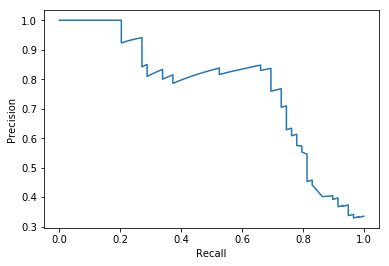

In [131]:
# generate a Precision-Recall curve
decision_values = clf.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, decision_values)

plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [132]:
the_auc = auc(recall, precision, reorder=True)
print('Area under R-C curve: '+'{:5.3f}'.format(the_auc))

Area under R-C curve: 0.765


The area under the curve indicates that the model is significantly better than random (0.50), but far from perfect (1.0).

# Avenues for Improvement

Minor tweaks, such as adding additional fields from the data set as features and changing the range/resolution of the model tuning parameters do not change the accuracy by more than a few points from 80%.

Things to try:
* The missing data in the Age column is currently replaced by the average within the whole data set, which likely introduces a fair amount of uncertainty.  A more rigorous way to estimate the missing data, or a different model that handles better data gaps might lessen this.
* Other subsets of available features or combinations of features could be tested. PCA could be tested, but may not add much with such a small amount of features.
* Other classification schemes could easily be compared: logistic regression, k-Nearest Neighbor, a neural network, etc.
